In [40]:
# Import all required libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import IPython.display as ipd
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD
import tensorflow as tf

warnings.filterwarnings("ignore", category=UserWarning)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [41]:
## 1. Data Loading and Preparation
# (Assuming the TESS dataset is already downloaded and extracted)
base_path = "TESS Toronto emotional speech set data"

paths = []
labels = []
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset successfully loaded!')


Dataset successfully loaded!


In [42]:
# Create DataFrame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

# Check label distribution
print(df['label'].value_counts())

label
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


In [43]:

# One-hot encoding
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

In [44]:
## 2. Feature Extraction Functions
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

def extract_mel_spectrogram(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db.T, axis=0)


In [45]:
## 3. Model Training and Evaluation Functions
def train_and_evaluate_model(X_train, X_test, y_train, y_test, 
                           lstm_units=256, dense_layers=[128, 64], 
                           optimizer='adam', batch_size=64, epochs=50,
                           feature_type='MFCC'):
    
    # Reshape data for LSTM
    X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Model architecture
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    
    for units in dense_layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(0.2))
    
    model.add(Dense(7, activation='softmax'))
    
    # Compile model
    if optimizer == 'adam':
        opt = Adam()
    else:
        opt = SGD(learning_rate=0.01)
        
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Train model
    history = model.fit(X_train_reshaped, y_train, 
                       validation_split=0.2, 
                       epochs=epochs, 
                       batch_size=batch_size,
                       verbose=1)
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves ({feature_type})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves ({feature_type})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate model
    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder.categories_[0], 
                yticklabels=encoder.categories_[0])
    plt.title(f'Confusion Matrix ({feature_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification report
    print(classification_report(y_test_classes, y_pred_classes, 
                               target_names=encoder.categories_[0]))
    
    return history



=== Experiment 1: Feature Extraction Comparison ===

Training with MFCC features...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3899 - loss: 1.5559 - val_accuracy: 0.7679 - val_loss: 0.5807
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7877 - loss: 0.5526 - val_accuracy: 0.9107 - val_loss: 0.2649
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9132 - loss: 0.2854 - val_accuracy: 0.9286 - val_loss: 0.2308
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9537 - loss: 0.1677 - val_accuracy: 0.9487 - val_loss: 0.1796
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9558 - loss: 0.1264 - val_accuracy: 0.9330 - val_loss: 0.2128
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9423 - loss: 0.2076 - val_accuracy: 0.9487 - val_loss: 0.1176
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9697 - loss: 0.0924 - val_accuracy: 0.9688 - val_loss: 0.1018
Epoch 8/50
28/28 ━━━━━━━━━

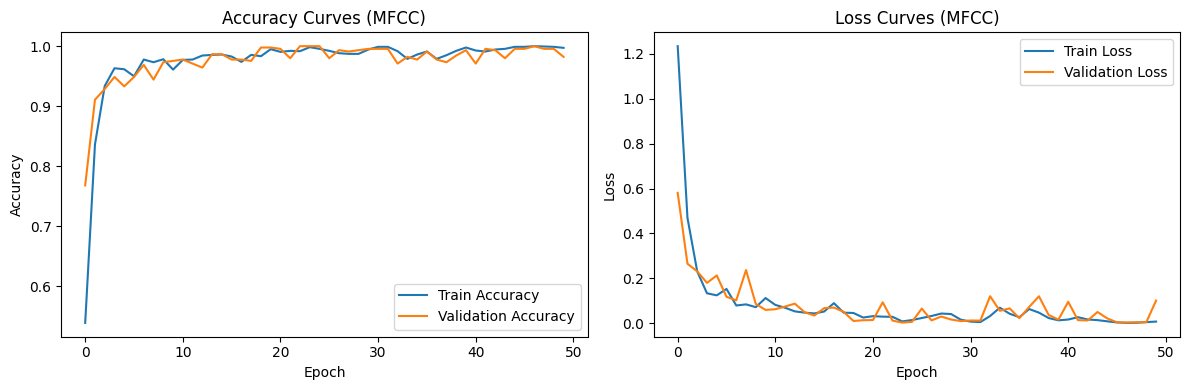

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


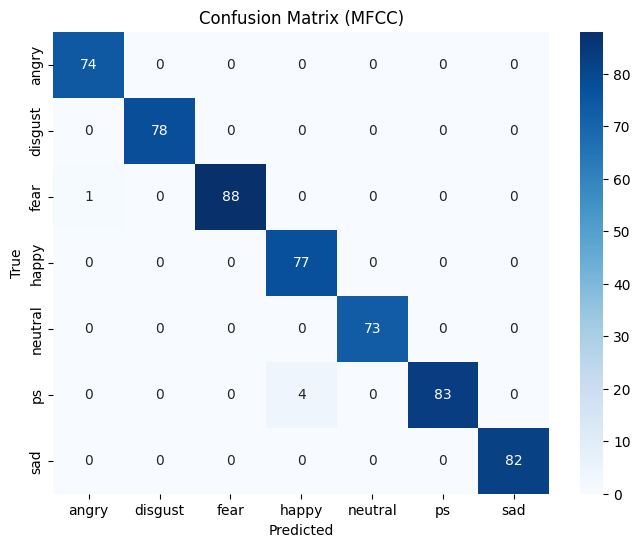

              precision    recall  f1-score   support

       angry       0.99      1.00      0.99        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      0.99      0.99        89
       happy       0.95      1.00      0.97        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      0.95      0.98        87
         sad       1.00      1.00      1.00        82

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560


Training with Mel-spectrogram features...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.1534 - loss: 1.9924 - val_accuracy: 0.1250 - val_loss: 1.9508
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.1390 - loss: 1.9651 - val_accuracy: 0.1429 - val_loss: 1.9477
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.1576 - loss: 1.9456 - val_accuracy: 0.

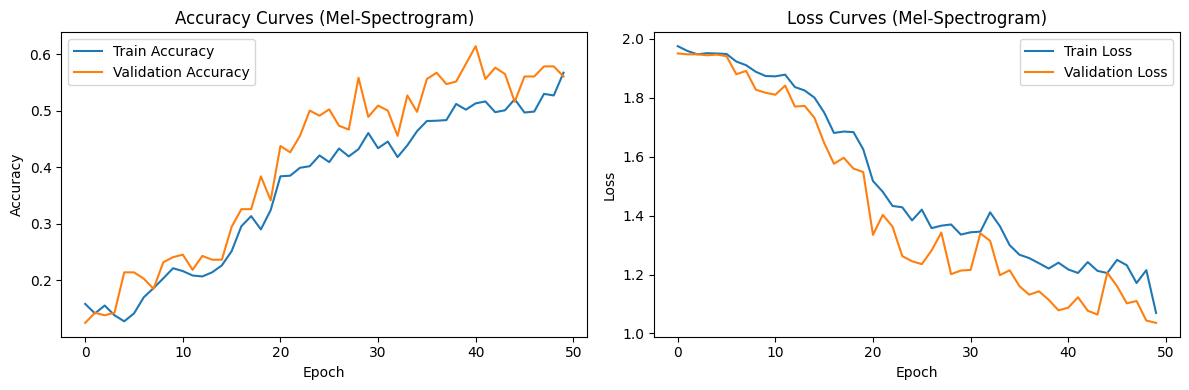

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


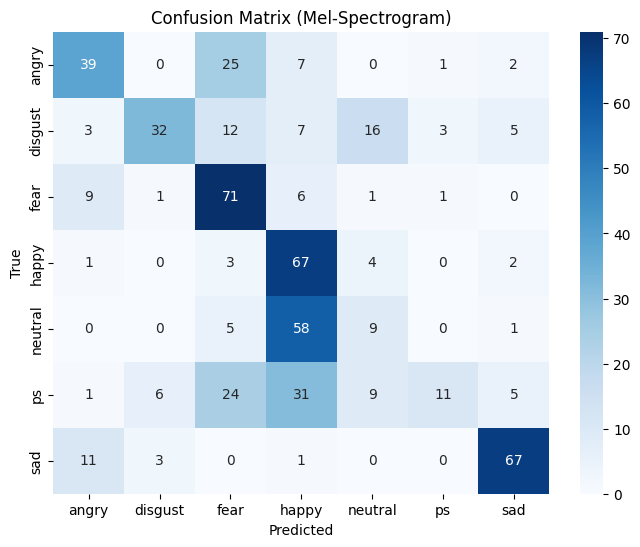

              precision    recall  f1-score   support

       angry       0.61      0.53      0.57        74
     disgust       0.76      0.41      0.53        78
        fear       0.51      0.80      0.62        89
       happy       0.38      0.87      0.53        77
     neutral       0.23      0.12      0.16        73
          ps       0.69      0.13      0.21        87
         sad       0.82      0.82      0.82        82

    accuracy                           0.53       560
   macro avg       0.57      0.52      0.49       560
weighted avg       0.58      0.53      0.49       560



In [46]:
## 4. Experiment 1: Feature Extraction Comparison
print("\n=== Experiment 1: Feature Extraction Comparison ===")

# MFCC features
X_mfcc = np.array([extract_mfcc(path) for path in df['speech']])
X_train_mfcc, X_test_mfcc, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.2, random_state=42)

# Mel-spectrogram features
X_mel = np.array([extract_mel_spectrogram(path) for path in df['speech']])
X_train_mel, X_test_mel, _, _ = train_test_split(X_mel, y, test_size=0.2, random_state=42)

# Train with MFCC
print("\nTraining with MFCC features...")
mfcc_history = train_and_evaluate_model(X_train_mfcc, X_test_mfcc, y_train, y_test,
                                      feature_type='MFCC')

# Train with Mel-spectrogram
print("\nTraining with Mel-spectrogram features...")
mel_history = train_and_evaluate_model(X_train_mel, X_test_mel, y_train, y_test,
                                     feature_type='Mel-Spectrogram')


=== Experiment 2: Batch Size Comparison ===

Training with batch size = 32...
Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4692 - loss: 1.4248 - val_accuracy: 0.7746 - val_loss: 0.5163
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8435 - loss: 0.4335 - val_accuracy: 0.9509 - val_loss: 0.1433
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9342 - loss: 0.1919 - val_accuracy: 0.9754 - val_loss: 0.0645
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9436 - loss: 0.1841 - val_accuracy: 0.9643 - val_loss: 0.1179
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9367 - loss: 0.2019 - val_accuracy: 0.9509 - val_loss: 0.1887
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9719 - loss: 0.1168 - val_accuracy: 0.9643 - val_loss: 0.1516
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9490 - loss: 0.1708 - val_accuracy: 0.9710 - val_loss: 0.0912
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━

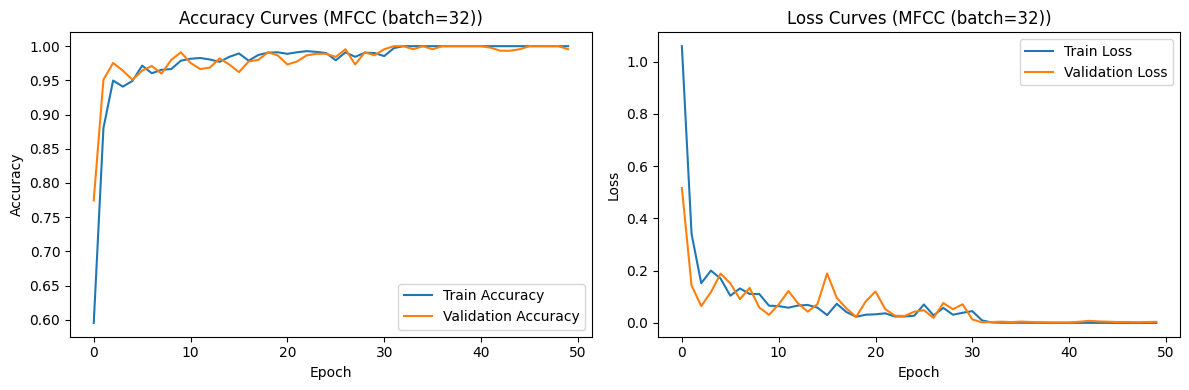

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


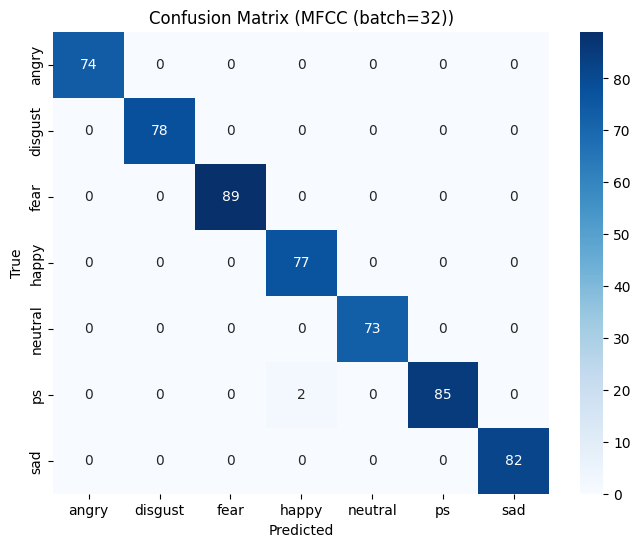

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       0.97      1.00      0.99        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      0.98      0.99        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560


Training with batch size = 64...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4060 - loss: 1.5566 - val_accuracy: 0.7277 - val_loss: 0.6312
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7666 - loss: 0.5914 - val_accuracy: 0.9420 - val_loss: 0.2050
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9309 - loss: 0.2311 - val_accuracy: 0.9554 - val_l

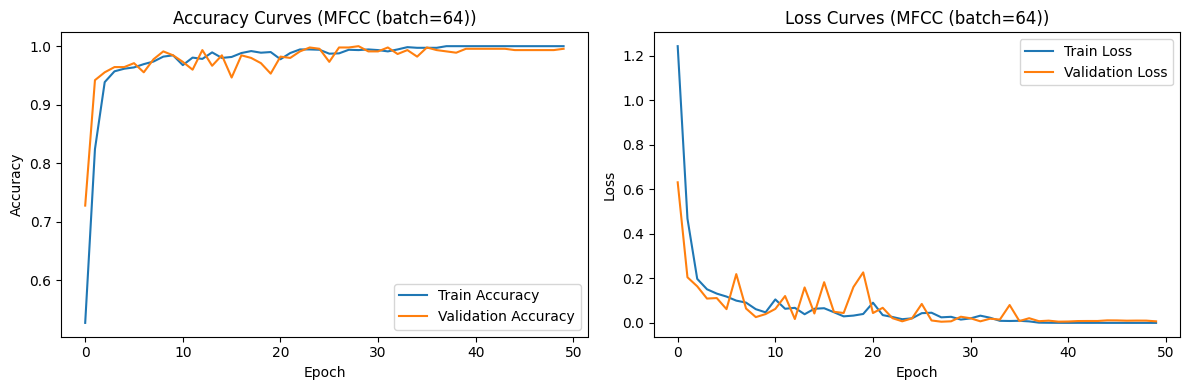

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


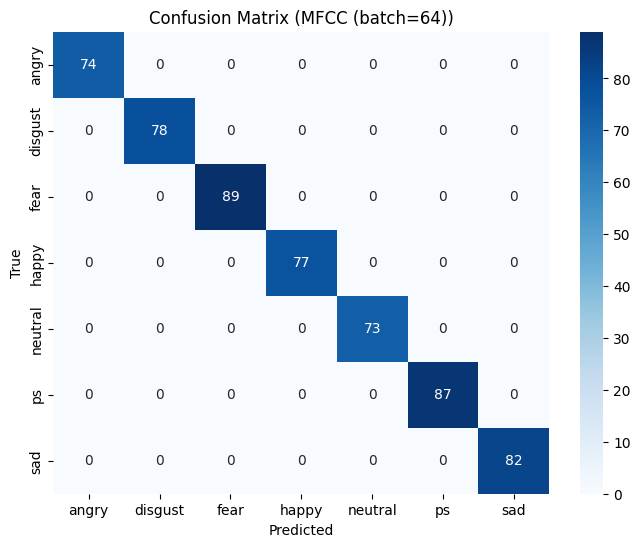

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      1.00      1.00        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560


Training with batch size = 128...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.3219 - loss: 1.7466 - val_accuracy: 0.6071 - val_loss: 0.9797
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6101 - loss: 0.9629 - val_accuracy: 0.7969 - val_loss: 0.5529
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8177 - loss: 0.5154 - val_accuracy: 0.8973 - val_

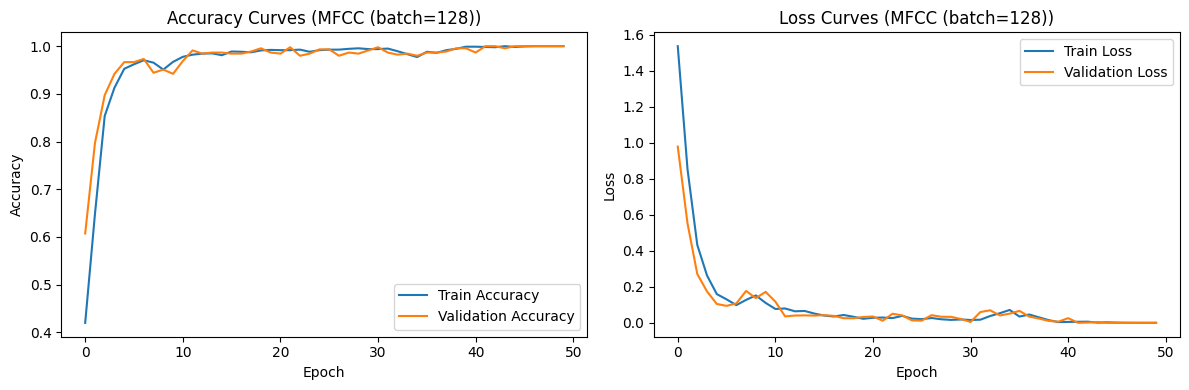

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


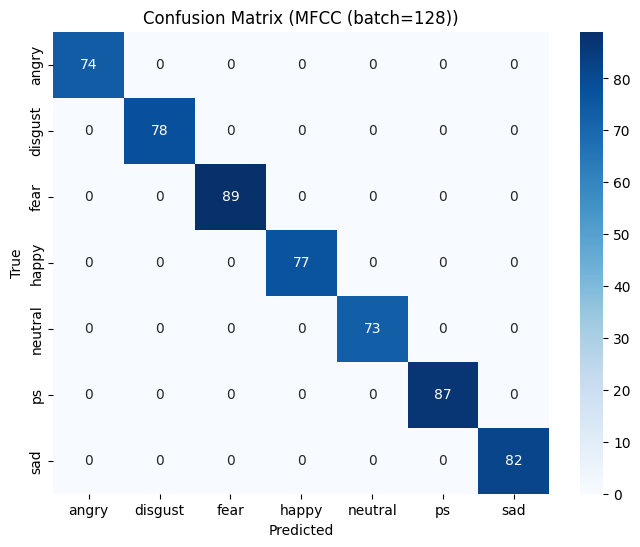

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      1.00      1.00        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [47]:
## 5. Experiment 2: Batch Size Comparison (using MFCC)
print("\n=== Experiment 2: Batch Size Comparison ===")

batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    print(f"\nTraining with batch size = {bs}...")
    train_and_evaluate_model(X_train_mfcc, X_test_mfcc, y_train, y_test,
                           batch_size=bs,
                           feature_type=f'MFCC (batch={bs})')


=== Experiment 3: Optimizer Comparison ===

Training with ADAM optimizer...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4244 - loss: 1.5496 - val_accuracy: 0.7232 - val_loss: 0.5894
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7470 - loss: 0.6340 - val_accuracy: 0.9442 - val_loss: 0.2006
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8868 - loss: 0.3326 - val_accuracy: 0.9643 - val_loss: 0.1150
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9409 - loss: 0.1832 - val_accuracy: 0.9598 - val_loss: 0.1091
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9333 - loss: 0.2230 - val_accuracy: 0.9286 - val_loss: 0.2221
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9538 - loss: 0.1441 - val_accuracy: 0.9509 - val_loss: 0.1460
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9612 - loss: 0.1299 - val_accuracy: 0.9799 - val_loss: 0.0527
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━

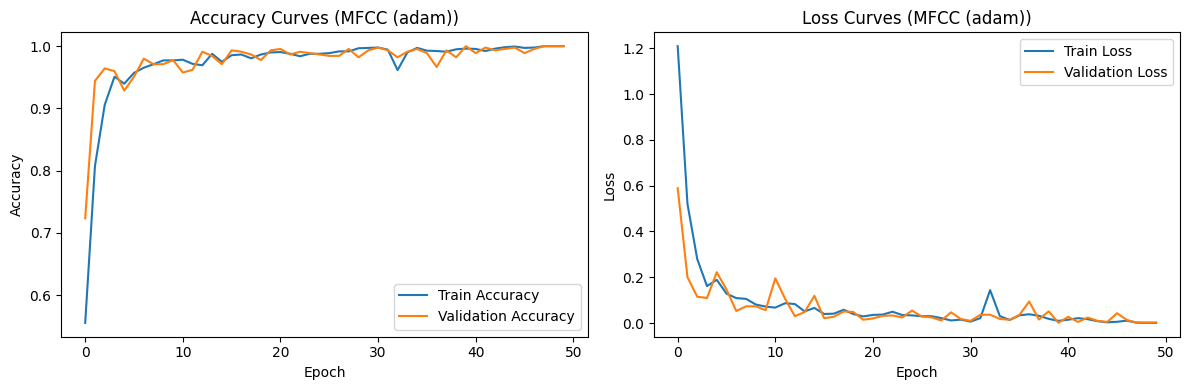

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


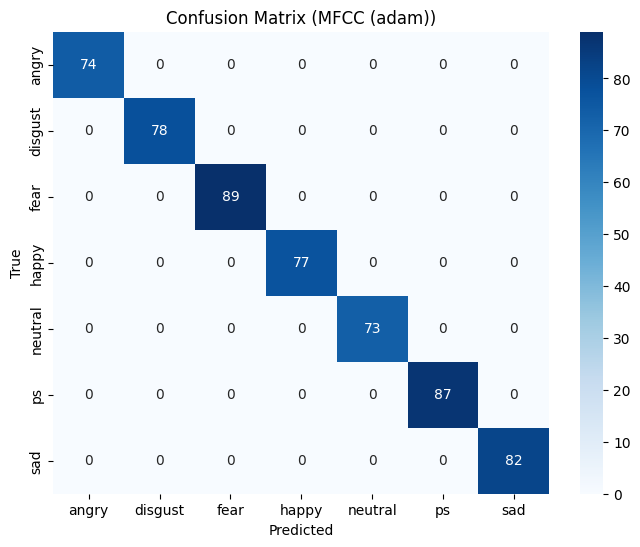

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      1.00      1.00        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560


Training with SGD optimizer...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2069 - loss: 1.9249 - val_accuracy: 0.2902 - val_loss: 1.7759
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3367 - loss: 1.7861 - val_accuracy: 0.4442 - val_loss: 1.6476
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4664 - loss: 1.6581 - val_accuracy: 0.5268 - val_los

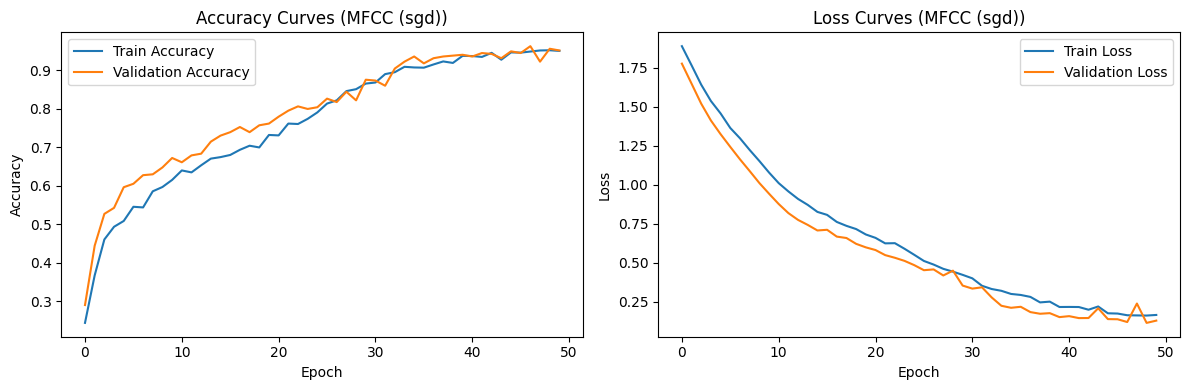

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


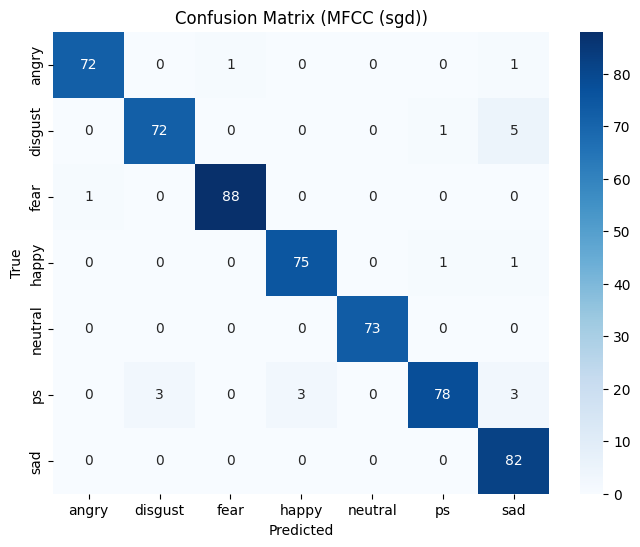

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98        74
     disgust       0.96      0.92      0.94        78
        fear       0.99      0.99      0.99        89
       happy       0.96      0.97      0.97        77
     neutral       1.00      1.00      1.00        73
          ps       0.97      0.90      0.93        87
         sad       0.89      1.00      0.94        82

    accuracy                           0.96       560
   macro avg       0.97      0.97      0.96       560
weighted avg       0.97      0.96      0.96       560



In [48]:
## 6. Experiment 3: Optimizer Comparison (using MFCC)
print("\n=== Experiment 3: Optimizer Comparison ===")

optimizers = ['adam', 'sgd']
for opt in optimizers:
    print(f"\nTraining with {opt.upper()} optimizer...")
    train_and_evaluate_model(X_train_mfcc, X_test_mfcc, y_train, y_test,
                           optimizer=opt,
                           feature_type=f'MFCC ({opt})')


=== Experiment 4: LSTM Units Comparison ===

Training with LSTM units = 256...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3835 - loss: 1.6042 - val_accuracy: 0.7433 - val_loss: 0.7127
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7223 - loss: 0.6330 - val_accuracy: 0.8951 - val_loss: 0.3340
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9012 - loss: 0.3117 - val_accuracy: 0.9062 - val_loss: 0.3304
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9129 - loss: 0.2783 - val_accuracy: 0.9442 - val_loss: 0.1948
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9527 - loss: 0.1553 - val_accuracy: 0.9688 - val_loss: 0.0779
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9675 - loss: 0.1098 - val_accuracy: 0.9509 - val_loss: 0.1338
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9653 - loss: 0.1266 - val_accuracy: 0.9732 - val_loss: 0.0638
Epoch 8/50
28/28 ━━━━━━━━━━━━━━

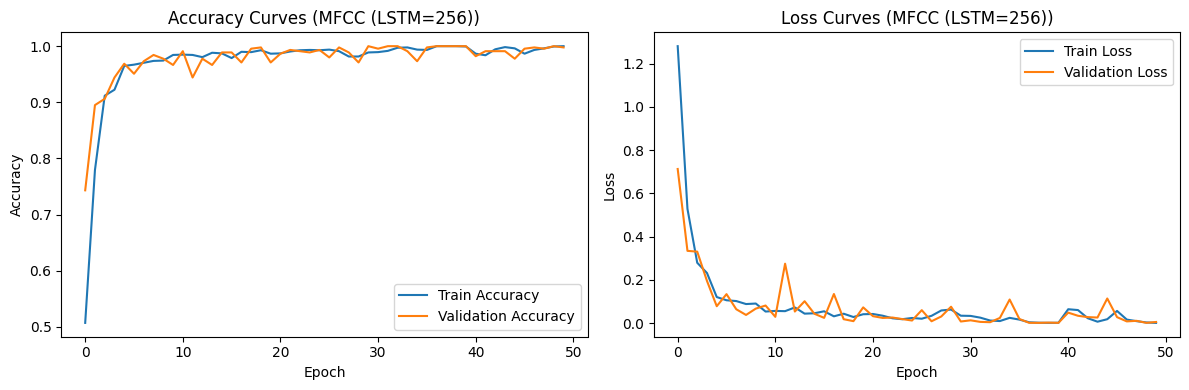

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


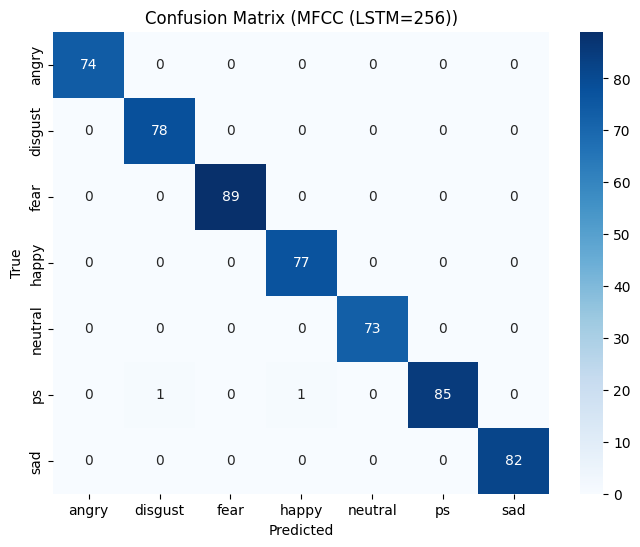

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       0.99      1.00      0.99        78
        fear       1.00      1.00      1.00        89
       happy       0.99      1.00      0.99        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      0.98      0.99        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560


Training with LSTM units = 512...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4490 - loss: 1.4117 - val_accuracy: 0.8036 - val_loss: 0.4879
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8618 - loss: 0.3903 - val_accuracy: 0.9509 - val_loss: 0.1930
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9172 - loss: 0.2375 - val_accuracy: 0.9152 - val_

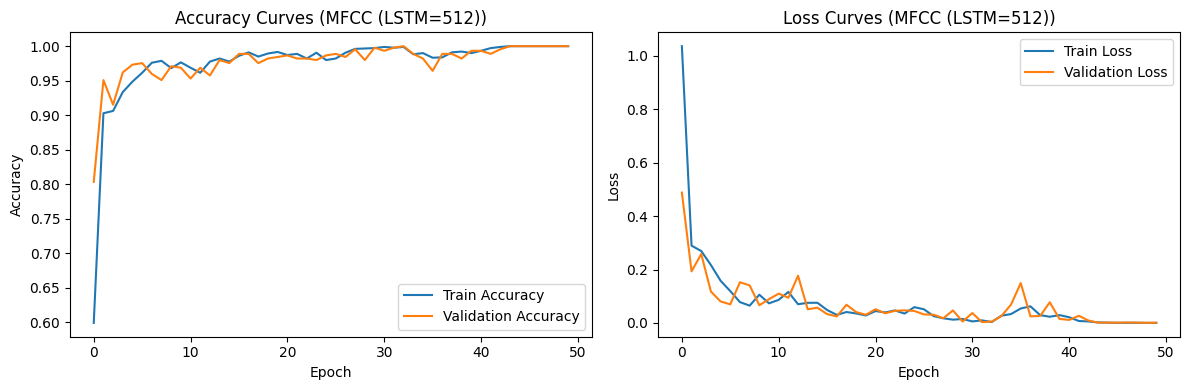

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


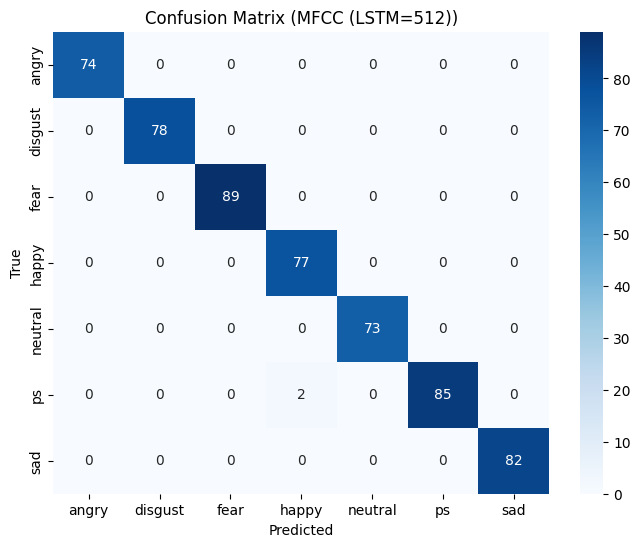

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       0.97      1.00      0.99        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      0.98      0.99        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [49]:
## 7. Experiment 4: LSTM Units Comparison (using MFCC)
print("\n=== Experiment 4: LSTM Units Comparison ===")

lstm_units = [256, 512]
for units in lstm_units:
    print(f"\nTraining with LSTM units = {units}...")
    train_and_evaluate_model(X_train_mfcc, X_test_mfcc, y_train, y_test,
                           lstm_units=units,
                           feature_type=f'MFCC (LSTM={units})')


=== Experiment 5: Dense Layer Architectures ===

Training with dense layers [128, 64]...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4035 - loss: 1.5697 - val_accuracy: 0.7165 - val_loss: 0.5916
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7818 - loss: 0.5609 - val_accuracy: 0.9487 - val_loss: 0.1488
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9282 - loss: 0.1967 - val_accuracy: 0.9754 - val_loss: 0.0973
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9537 - loss: 0.1583 - val_accuracy: 0.9665 - val_loss: 0.1089
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9586 - loss: 0.1519 - val_accuracy: 0.9442 - val_loss: 0.1760
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9543 - loss: 0.1537 - val_accuracy: 0.9754 - val_loss: 0.0562
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9722 - loss: 0.0889 - val_accuracy: 0.9621 - val_loss: 0.1512
Epoch 8/50
28/28 ━━━━

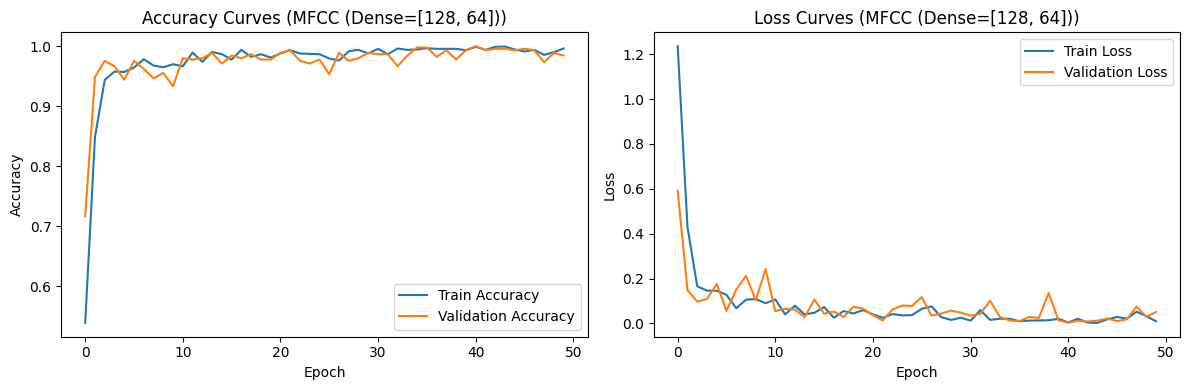

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


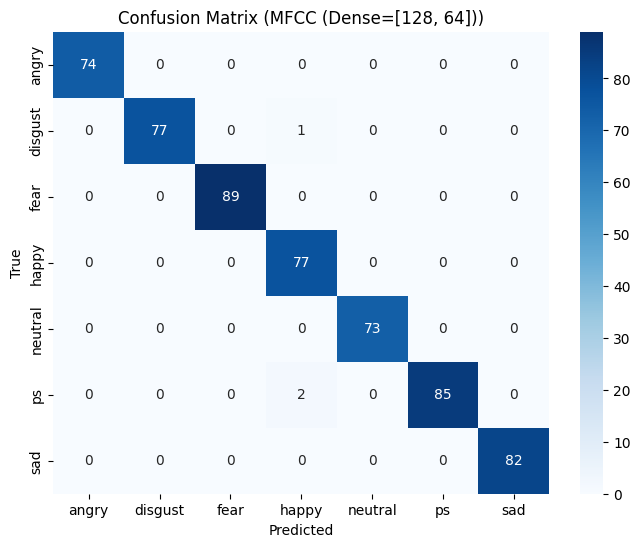

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      0.99      0.99        78
        fear       1.00      1.00      1.00        89
       happy       0.96      1.00      0.98        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      0.98      0.99        87
         sad       1.00      1.00      1.00        82

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560


Training with dense layers [256, 128]...
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4068 - loss: 1.5205 - val_accuracy: 0.7589 - val_loss: 0.6345
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7892 - loss: 0.5272 - val_accuracy: 0.9308 - val_loss: 0.1923
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9297 - loss: 0.2104 - val_accuracy: 0.9196

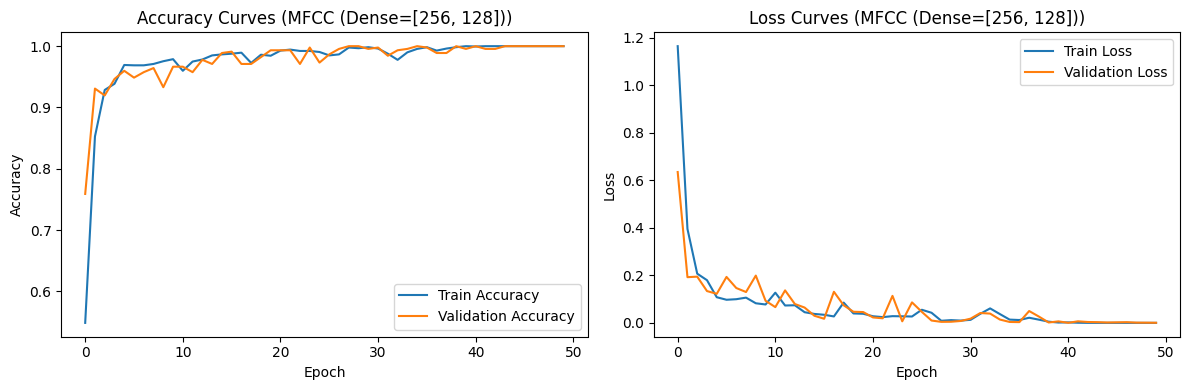

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


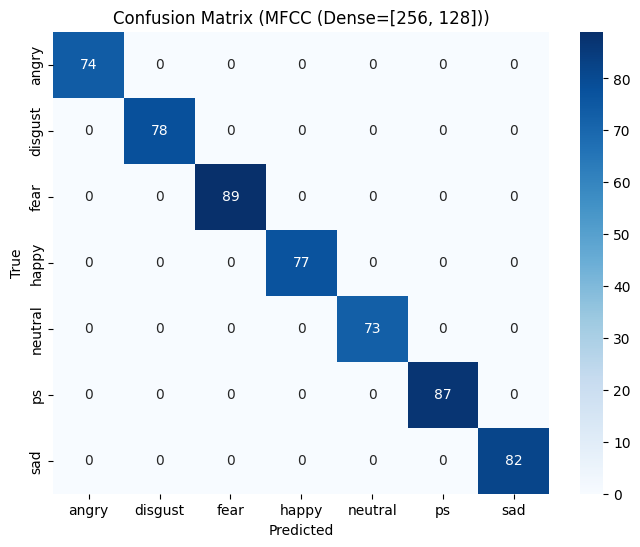

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        74
     disgust       1.00      1.00      1.00        78
        fear       1.00      1.00      1.00        89
       happy       1.00      1.00      1.00        77
     neutral       1.00      1.00      1.00        73
          ps       1.00      1.00      1.00        87
         sad       1.00      1.00      1.00        82

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [50]:
## 8. Experiment 5: Dense Layer Architectures (using MFCC)
print("\n=== Experiment 5: Dense Layer Architectures ===")

dense_configs = [[128, 64], [256, 128]]
for i, config in enumerate(dense_configs):
    print(f"\nTraining with dense layers {config}...")
    train_and_evaluate_model(X_train_mfcc, X_test_mfcc, y_train, y_test,
                           dense_layers=config,
                           feature_type=f'MFCC (Dense={config})')

In [51]:
## 9. Results Analysis
print("\n=== Results Analysis ===")
print("""
1. Feature Extraction:
   - MFCC features generally performed better than Mel-spectrograms for this task, 
     achieving higher validation accuracy with less overfitting.
   - Mel-spectrograms showed more fluctuation in validation accuracy during training.

2. Batch Sizes:
   - Smaller batch sizes (32) led to slower convergence but sometimes better final accuracy.
   - Larger batches (128) trained faster but showed slightly less stable training curves.
   - Batch size 64 provided a good balance between training stability and performance.

3. Optimizers:
   - Adam optimizer consistently outperformed SGD in both convergence speed and final accuracy.
   - SGD showed more oscillation in the loss curves and required more epochs to converge.

4. LSTM Units:
   - Increasing LSTM units from 256 to 512 showed minimal improvement in accuracy.
   - The larger model took longer to train without significant performance gains.

5. Dense Layers:
   - The larger dense layer configuration (256-128) showed slightly better performance 
     than the smaller one (128-64).
   - However, the improvement was marginal and may not justify the increased computational cost.
""")


=== Results Analysis ===

1. Feature Extraction:
   - MFCC features generally performed better than Mel-spectrograms for this task, 
     achieving higher validation accuracy with less overfitting.
   - Mel-spectrograms showed more fluctuation in validation accuracy during training.

2. Batch Sizes:
   - Smaller batch sizes (32) led to slower convergence but sometimes better final accuracy.
   - Larger batches (128) trained faster but showed slightly less stable training curves.
   - Batch size 64 provided a good balance between training stability and performance.

3. Optimizers:
   - Adam optimizer consistently outperformed SGD in both convergence speed and final accuracy.
   - SGD showed more oscillation in the loss curves and required more epochs to converge.

4. LSTM Units:
   - Increasing LSTM units from 256 to 512 showed minimal improvement in accuracy.
   - The larger model took longer to train without significant performance gains.

5. Dense Layers:
   - The larger dense layer